# **Drive Mounting**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Libraries Import:


In [ ]:
import os
import numpy as np
import nibabel as nib
!pip install antspyx
import ants
import copy
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 KB 9.2 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
import os
import numpy as np
import nibabel as nib
import ants
import copy
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt



In [ ]:
########NORMALIZE###################################

def normalize_image(im):
    min_intensity = np.min(im)
    max_intensity = np.max(im)
    normalized_image = (im - min_intensity) / (max_intensity - min_intensity)


    return normalized_image

def get_voxel_coordenates(input_data,roi,random_pad=(0, 0, 0),step_size=(1, 1, 1)):
    # compute initial padding
    r_pad = np.random.randint(random_pad[0]+1) if random_pad[0] > 0 else 0
    c_pad = np.random.randint(random_pad[1]+1) if random_pad[1] > 0 else 0
    s_pad = np.random.randint(random_pad[2]+1) if random_pad[2] > 0 else 0

    # precompute the sampling points based on the input
    sampled_data = np.zeros_like(input_data)
    for r in range(r_pad, input_data.shape[0], step_size[0]):
        for c in range(c_pad, input_data.shape[1], step_size[1]):
            for s in range(s_pad, input_data.shape[2], step_size[2]):
                sampled_data[r, c, s] = 1

    # apply sampled points to roi and extract sample coordenates
    [x, y, z] = np.where(roi * sampled_data.squeeze())

    # return as a list of tuples
    return [(x_, y_, z_) for x_, y_, z_ in zip(x, y, z)]
########################data loading ############################

class MRI_DataPatchLoader(Dataset):
  def __init__(self,input_data,labels,rois,patch_size,apply_padding,normalize,sampling_type,sampling_step,transform=None):
    self.patch_size = patch_size
    self.patch_half = tuple([idx // 2 for idx in patch_size])
    self.input_scans, self.label_scans, self.roi_scans = self.load_scans(input_data,labels,rois,apply_padding)
   
    self.input_train_dim = (1, ) + self.patch_size#(1,32,32,32)
    self.input_label_dim = (1, ) + self.patch_size#(1,32,32,32)

    if normalize:
      for i in range(len(self.input_scans)):
        self.input_scans[i][0] = normalize_data(self.input_scans[i][0])

    self.sampling_type=sampling_type
    self.sampling_step=sampling_step
    # Build the patch indexes based on the image index and the voxel coordenates
    self.patch_indexes = self.generate_patch_indexes()
    print('> DATA: Training sample size:', len(self.patch_indexes))
    self.transform=transform

  def __len__(self):
    return len(self.patch_indexes)

  def __getitem__(self, idx):
    im_ = self.patch_indexes[idx][0]
    center = self.patch_indexes[idx][1]

    slice_ = [slice(c_idx-p_idx, c_idx+s_idx-p_idx)
              for (c_idx, p_idx, s_idx) in zip(center,self.patch_half,self.patch_size)]
    # get current patches for both training data and labels
    input_train = np.stack([self.input_scans[im_][0][tuple(slice_)]], axis=0)
    input_label = np.expand_dims(self.label_scans[im_][0][tuple(slice_)], axis=0)

    # check dimensions and put zeros if necessary
    if input_train.shape != self.input_train_dim:
        print('error in patch', input_train.shape, self.input_train_dim)
        input_train = np.zeros(self.input_train_dim).astype('float32')
    if input_label.shape != self.input_label_dim:
        print('error in label')
        input_label = np.zeros(self.input_label_dim).astype('float32')
    if self.transform:
        input_train, input_label = self.transform([input_train,input_label])
    return input_train, input_label

  def apply_padding(self,input_data):#Apply padding to edges in order to avoid overflow
    padding = tuple((idx, size-idx) for idx, size in zip(self.patch_half, self.patch_size))#((16, 16), (16, 16), (16, 16))
    padded_image = np.pad(input_data,padding,mode='constant',constant_values=0)#0 value as background
    return padded_image

  def load_scans(self,input_data,label_data,roi_data,apply_padding=True):
    """Applying padding to input scans. Loading simultaneously input data and
        labels in order to discard missing data in both sets."""
    input_scans=[]
    label_scans=[]
    roi_scans=[]

    for s in input_data.keys():
      if apply_padding:
        input_ = [self.apply_padding((nib.load(input_data[s][0]).get_data().astype('float32')).squeeze())]
        label_ = [self.apply_padding((nib.load(label_data[s][0]).get_data().astype('float32')).squeeze())]
        roi_ = [self.apply_padding((nib.load(roi_data[s][0]).get_data().astype('float32')).squeeze())]
        input_scans.append(input_)
        label_scans.append(label_)
        roi_scans.append(roi_)
      else:
        input_ = [(nib.load(input_data[s][0]).get_data().astype('float32')).squeeze()]
        label_ = [(nib.load(label_data[s][0]).get_data().astype('float32')).squeeze()]
        roi_ = [(nib.load(roi_data[s][0]).get_data().astype('float32')).squeeze()]
        input_scans.append(input_)
        label_scans.append(label_)
        roi_scans.append(roi_)
      print('> DATA: Loaded scan', s, 'roi size:',np.sum(roi_[0] > 0),' label_size: ', np.sum(label_[0] > 0))
    return input_scans, label_scans, roi_scans


  def get_candidate_voxels(input_mask, label_mask, roi_mask):
    if self.sampling_type == 'all':
    sampled_mask = input_mask > 0
    elif self.sampling_type == 'mask':
    sampled_mask = roi_mask > 0

  def get_voxel_coordenates(image, mask, step_size=1):
     x, y, z = np.where(mask)
     voxel_coords = [(x[i], y[i], z[i]) for i in range(len(x)) if i % step_size == 0]
     return voxel_coords
    
    
    return sampled_mask

In [ ]:

def invert_padding(input_data, patch_size):
    patch_half = tuple([idx // 2 for idx in patch_size])
    slices = [slice(p, -p) for p in patch_half]
    return input_data[slices]
###### get patches ############################################################################
def get_patches(input_data, centers, patch_size=(15, 15, 15)):
    patches = []
    list_of_tuples = all([isinstance(center, tuple) for center in centers])
    sizes_match = [len(center) == len(patch_size) for center in centers]
    if list_of_tuples and sizes_match:
        # apply padding to the input image and re-compute the voxel coordenates
        # according to the new dimension
        padded_image = apply_padding(input_data, patch_size)
        patch_half = tuple([idx // 2 for idx in patch_size])
        new_centers = [map(add, center, patch_half) for center in centers]
        # compute patch locations
        slices = [[slice(c_idx-p_idx, c_idx+s_idx-p_idx)
                   for (c_idx, p_idx, s_idx) in zip(center,
                                                    patch_half,
                                                    patch_size)]
                  for center in new_centers]

        # extact patches
        patches = [padded_image[tuple(idx)] for idx in slices]

    return np.array(patches)

def get_data_channels(image_path,scan_names,ref_voxels,patch_shape,normalize=False):
    scan_path = os.path.join(image_path, str(scan_names[0]))
    current_scan = nib.load(scan_path).get_data().squeeze()

    if normalize:
        current_scan = normalize_data(current_scan)

    patches = get_patches(current_scan,ref_voxels,patch_shape)    
    patches = np.expand_dims(patches, axis=1)

    return patches

def get_candidate_voxels(input_mask,  step_size):#Extract candidate patches.
    candidate_voxels = input_mask > 0#(256,128,256) its True False array

    voxel_coords = get_voxel_coordenates(input_mask,
                                          candidate_voxels,
                                          step_size=step_size) #saray scans me se aik ke 212 regions return kiye hein
    return voxel_coords

def get_inference_patches(scan_path, input_data, roi, patch_shape, step, normalize=True):
    # get candidate voxels
    mask_image = nib.load(os.path.join(scan_path, roi))

    ref_voxels = get_candidate_voxels(mask_image.get_data(),step)#(x,y,z)
    # input images stacked as channels
    test_patches = get_data_channels(scan_path, #ye main function hai. sari inference krne ka
                                     input_data,
                                     ref_voxels,
                                     patch_shape,
                                     normalize=normalize)


    return test_patches, ref_voxels

#//***************************************************************************
def invert_padding(padded_image, patch_size):
    patch_half = tuple([idx // 2 for idx in patch_size])
    padding = tuple((idx, size-idx)
                    for idx, size in zip(patch_half, patch_size))

    return padded_image[padding[0][0]:-padding[0][1],
                        padding[1][0]:-padding[1][1],
                        padding[2][0]:-padding[2][1]]
def reconstruct_image(input_data, centers, output_size):
    # apply a padding around edges before writing the results
    patch_size = input_data[0, :].shape
    out_image = apply_padding(np.zeros(output_size), patch_size)
    patch_half = tuple([idx // 2 for idx in patch_size])
    new_centers = [map(add, center, patch_half) for center in centers]
    # compute patch locations
    slices = [[slice(c_idx-p_idx, c_idx+s_idx-p_idx)
               for (c_idx, p_idx, s_idx) in zip(center,
                                                patch_half,
                                                patch_size)]
              for center in new_centers]

    # for each patch, sum it to the output patch and
    # then update the frequency matrix
    freq_count = np.zeros_like(out_image)
    for patch, slide in zip(input_data, slices):
        out_image[tuple(slide)] += patch
        freq_count[tuple(slide)] += np.ones(patch_size)

    # invert the padding applied for patch writing
    out_image = invert_padding(out_image, patch_size)
    freq_count = invert_padding(freq_count, patch_size)

    # the reconstructed image is the mean of all the patches
    out_image /= freq_count
    out_image[np.isnan(out_image)] = 0

    return out_image

 

In [ ]:

def set_device():
    # check if GPU is available
    if torch.cuda.is_available():
        # set device to GPU
        device = "cuda:0"
    else:
        # set device to CPU
        device = "cpu"
    # return device
    return torch.device(device)

def mask_image(im):
  return (im > 0).astype('float32')


def imshow(inp, title=None):
    """Imshow for datagenerator patches"""
    # transpose input array and clip values between 0 and 1
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    # display image using imshow
    plt.imshow(inp)
    # set title if provided
    if title is not None:
        plt.title(title)
    # pause plot for a short period of time
    plt.pause(0.001)


def dice_loss(input, target):
    smooth = 1.
    total_loss = 0
    n_classes = 4
    for c in range(n_classes):
        # flatten target and input arrays for class c
        tflat = torch.flatten(target == c)
        iflat = torch.flatten(input[:, c, :, :, :])
        # calculate intersection between target and input arrays
        intersection = torch.sum(iflat * tflat)
        # calculate Dice loss for class c
        loss = (2. * intersection + smooth) / (torch.sum(iflat) + torch.sum(tflat) + smooth)
        # update total loss
        total_loss += loss
    # calculate average Dice loss across all classes
    total_loss /= n_classes
    # return 1 - average Dice loss
    return 1 - total_loss


def calc_loss(pred, y,thresh=0.65):
  dice = dice_loss(pred, y)
  cross_entropy = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),y.squeeze(dim=1).long())

  loss = (thresh*dice) + ((1.0-thresh)*cross_entropy)
  return loss

def evaluation(training_path):
  test_scans = os.listdir(training_path)
  metrics = np.zeros((len(test_scans), 9))
  scan_id_list = []
  normalize=True
  th=0.5
  normalize=True
  for i, scan_name in enumerate(test_scans):
    real_path=os.path.join(training_path,scan_name)
    Image = ants.image_read(os.path.join(real_path, '{}.nii.gz'.format(scan_name)))
    infer_patches, coordenates = get_inference_patches(scan_path=real_path,input_data=['{}.nii.gz'.format(scan_name)],roi='{}_brainmask.nii.gz'.format(scan_name),patch_shape=patch_size,step=sampling_step,normalize=normalize)
    
    lesion_out = np.zeros((infer_patches.shape[0], 4, infer_patches.shape[2], infer_patches.shape[3],infer_patches.shape[4]), dtype='float32')#(212, 4, 32, 32, 32)
    batch_size =batchsize
    model.eval()
    with torch.no_grad():
      for b in range(0, len(lesion_out), batch_size):
        x = torch.tensor(infer_patches[b:b + batch_size]).to(device)
        pred = model(x)
        lesion_out[b:b + batch_size] = pred.cpu().numpy()
    
    # reconstruct image takes the inferred patches, the patches coordenates and the image size as inputs
    lesion_prob = np.expand_dims(reconstruct_image(lesion_out[:, 0],coordenates,Image.shape), axis=0)#(1, 256, 128, 256)
    lesion_prob2 = np.expand_dims(reconstruct_image(lesion_out[:, 1],coordenates,Image.shape), axis=0)
    lesion_prob3 = np.expand_dims(reconstruct_image(lesion_out[:, 2],coordenates,Image.shape), axis=0)
    lesion_prob4 = np.expand_dims(reconstruct_image(lesion_out[:, 3],coordenates,Image.shape), axis=0)
    tissue_seg = np.stack((lesion_prob, lesion_prob2, lesion_prob3, lesion_prob4), axis=0).squeeze()

    tissue_seg = np.argmax(tissue_seg, axis=0)

    CSF = tissue_seg == 1
    GM = tissue_seg == 2
    WM = tissue_seg == 3

    # binarize the results
    lesion_prob = (lesion_prob > th).astype('uint8')

    # evaluate the results
    gt = ants.image_read(os.path.join(real_path, '{}_seg.nii.gz'.format(scan_name)))
    dsc_CSF = DSC_seg(gt.numpy() == 1, CSF)
    dsc_GM = DSC_seg(gt.numpy() == 2, GM)
    dsc_WM = DSC_seg(gt.numpy() == 3, WM)

    hd_CSF = HD(gt.numpy() == 1, CSF)
    hd_GM = HD(gt.numpy() == 2, GM)
    hd_WM = HD(gt.numpy() == 3, WM)

    vd_CSF = PVE(gt.numpy() == 1, CSF)
    vd_GM = PVE(gt.numpy() == 2, GM)
    vd_WM = PVE(gt.numpy() == 3, WM)

    metrics[i] = [dsc_CSF, dsc_GM, dsc_WM, hd_CSF,hd_GM,hd_WM, vd_CSF,vd_GM,vd_WM]
    scan_id_list.append(scan_name)

    print('SCAN:', scan_name, 'dice_CSF: ', dsc_CSF, 'dice_GM:', dsc_GM, 'dice_WM:', dsc_WM, 'hd_CSF: ',hd_CSF,'hd_GM: ',hd_GM,'hd_WM: ',hd_WM,'vd_CSF: ',vd_CSF,'vd_GM: ',vd_GM,'vd_WM: ',vd_WM)

    # # save as nifti image is necessary
    seg_img = ants.from_numpy(tissue_seg.astype('uint8'))
    seg_img = ants.copy_image_info(Image, seg_img)
    # write segmented image to folder
    seg_path = "{}/{}.nii.gz".format(tmpdir, scan_name)
    #print(seg_path)
    ants.image_write(seg_img, seg_path)

  metrics_df = {'scan_id':scan_id_list, 'DSC_CSF':metrics[:, 0],'DSC_GM':metrics[:, 1],'DSC_WM':metrics[:, 2], 'hd_CSF':metrics[:, 3],'hd_GM':metrics[:, 4],'hd_WM':metrics[:, 5],
                'vd_CSF':metrics[:, 6],'vd_GM':metrics[:, 7],'vd_WM':metrics[:, 8]}
  m = pd.DataFrame(metrics_df, columns=['scan_id', 'DSC_CSF', 'DSC_GM', 'DSC_WM','hd_CSF','hd_GM','hd_WM','vd_CSF','vd_GM','vd_WM'])
  m_mean = m.describe().T
  return m_mean


def evaluation_test(test_path):
  test_scans = os.listdir(test_path)
  metrics = np.zeros((len(test_scans), 9))
  scan_id_list = []
  normalize=True
  th=0.5
  for i, scan_name in enumerate(test_scans):
    real_path=os.path.join(test_path,scan_name)
    Image = ants.image_read(os.path.join(real_path, '{}.nii.gz'.format(scan_name)))
    infer_patches, coordenates = get_inference_patches(scan_path=real_path,input_data=['{}.nii.gz'.format(scan_name)],roi='{}_brainmask.nii.gz'.format(scan_name),patch_shape=patch_size,step=sampling_step,normalize=normalize)
    
    lesion_out = np.zeros((infer_patches.shape[0], 4, infer_patches.shape[2], infer_patches.shape[3],infer_patches.shape[4]), dtype='float32')#(212, 4, 32, 32, 32)
    batch_size =batchsize
    model.eval()
    with torch.no_grad():
      for b in range(0, len(lesion_out), batch_size):
        x = torch.tensor(infer_patches[b:b + batch_size]).to(device)
        pred = model(x)
        lesion_out[b:b + batch_size] = pred.cpu().numpy()
    
    # reconstruct image takes the inferred patches, the patches coordenates and the image size as inputs
    lesion_prob = np.expand_dims(reconstruct_image(lesion_out[:, 0],coordenates,Image.shape), axis=0)#(1, 256, 128, 256)
    lesion_prob2 = np.expand_dims(reconstruct_image(lesion_out[:, 1],coordenates,Image.shape), axis=0)
    lesion_prob3 = np.expand_dims(reconstruct_image(lesion_out[:, 2],coordenates,Image.shape), axis=0)
    lesion_prob4 = np.expand_dims(reconstruct_image(lesion_out[:, 3],coordenates,Image.shape), axis=0)
    tissue_seg = np.stack((lesion_prob, lesion_prob2, lesion_prob3, lesion_prob4), axis=0).squeeze()

    tissue_seg = np.argmax(tissue_seg, axis=0)

    CSF = tissue_seg == 1
    GM = tissue_seg == 2
    WM = tissue_seg == 3

    # binarize the results
    lesion_prob = (lesion_prob > th).astype('uint8')
    # # save as nifti image is necessary
    seg_img = ants.from_numpy(tissue_seg.astype('uint8'))
    seg_img = ants.copy_image_info(Image, seg_img)
    # write segmented image to folder
    seg_path = "{}/{}.nii.gz".format(tmpdir, scan_name)
    #print(seg_path)
    ants.image_write(seg_img, seg_path)

In [ ]:

def true_pos(gt, mask):
    temp1 = np.array(gt).astype(dtype=np.bool)
    temp2 = np.array(mask).astype(dtype=np.bool)
    return np.count_nonzero(np.logical_and(temp1, temp2))#compute the number of true positive voxels between mask and gt
def DSC_seg(gt, mask):
    """
    Inputs:
    - gt: 3D np.ndarray, reference image (ground truth)
    - mask: 3D np.ndarray, input MRI mask

    Output:
    - (float) Voxelwise Dice coefficient between the input and gt mask
    """
    A = np.sum(np.array(gt).astype(dtype=np.bool))
    B = np.sum(np.array(mask).astype(dtype=np.bool))

    return 2.0 * true_pos(gt, mask) / (A + B) \
        if (A + B) > 0 else 0

from scipy.ndimage.morphology import binary_erosion as imerode
from sklearn.neighbors import NearestNeighbors

def eucl_distance(a, b):
    nbrs_a = NearestNeighbors(n_neighbors=1,algorithm='kd_tree').fit(a) if a.size > 0 else None
    nbrs_b = NearestNeighbors(n_neighbors=1,algorithm='kd_tree').fit(b) if b.size > 0 else None
    distances_a, _ = nbrs_a.kneighbors(b) if nbrs_a and b.size > 0 else ([np.inf], None)
    distances_b, _ = nbrs_b.kneighbors(a) if nbrs_b and a.size > 0 else ([np.inf], None)
    return [distances_a, distances_b]
def surface_distance(gt, mask, spacing=list((1, 1, 1))):#Compute the surface distance between the input mask and gt mask
    a = np.array(gt).astype(dtype=np.bool)
    b = np.array(mask).astype(dtype=np.bool)
    a_bound = np.stack(np.where(np.logical_and(a, np.logical_not(imerode(a)))), axis=1) * spacing
    b_bound = np.stack(np.where(np.logical_and(b, np.logical_not(imerode(b)))), axis=1) * spacing
    return eucl_distance(a_bound, b_bound)
def HD(gt, mask, spacing=(1, 1, 1)):
    distances = surface_distance(gt, mask, spacing)
    return np.max([np.max(distances[0]), np.max(distances[1])])

def PVE(gt, mask):
    A = np.sum(np.array(gt).astype(dtype=np.bool))
    B = np.sum(np.array(mask).astype(dtype=np.bool))
    pve = np.abs(float(B - A) / A)
    return pve

In [ ]:


class Unet(nn.Module):#Basic 3D U-net model
    def __init__(self, input_size, output_size, dropout_rate=0.2):
        super(Unet, self).__init__()
        # convolution1 down
        self.convolution1 = nn.Conv3d(in_channels=input_size,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        
        # normalization_dropout 1
        self.normalization1 = nn.InstanceNorm3d(32)
        self.dropout1 = nn.Dropout3d(p=dropout_rate)

        # max-pooling 1
        self.pooling1 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=2,
                               stride=2)
        # convolution2 down
        self.convolution2 = nn.Conv3d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        
        # normalization_dropout 2
        self.normalization2 = nn.InstanceNorm3d(64)
        self.dropout2 = nn.Dropout3d(p=dropout_rate)

        # max-pooling 2
        self.pooling2 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=2,
                               stride=2)
        # convolution3 down
        self.convolution3 = nn.Conv3d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        
        # normalization_dropout 3
        self.normalization3 = nn.InstanceNorm3d(128)
        self.dropout3 = nn.Dropout3d(p=dropout_rate)

        # max-pooling 3
        self.pooling3 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=2,
                               stride=2)
        # convolution4 down
        self.convolution4 = nn.Conv3d(in_channels=128,
                               out_channels=256,
                               kernel_size=3,
                               padding=1)
        
        # normalization_dropout 4
        self.normalization4 = nn.InstanceNorm3d(256)
        self.dropout4 = nn.Dropout3d(p=dropout_rate)

        # up-sample convolution4
        self.up1 = nn.ConvTranspose3d(in_channels=256,
                                      out_channels=128,
                                      kernel_size=2,
                                      stride=2)        
        # conv 5 (add up1 + convolution3)
        self.convolution5 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # up-sample convolution5
        self.up2 = nn.ConvTranspose3d(in_channels=128,
                                      out_channels=64,
                                      kernel_size=2,
                                      stride=2)
        # convolution6 (add up2 + convolution2) 
        self.convolution6 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # up 3
        self.up3 = nn.ConvTranspose3d(in_channels=64,
                                      out_channels=32,
                                      kernel_size=2,
                                      stride=2)
        # convolution7 (add up3 + convolution1)
        self.convolution7 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        # convolution8 (classification)
        self.convolution8 = nn.Conv3d(in_channels=32,
                               out_channels=output_size,
                               kernel_size=1)

    def forward(self, x):
        # encoder
        x1 = F.relu(self.convolution1(x))
        x1 = self.normalization1(x1)
        x1 = self.dropout1(x1)
        x1p = self.pooling1(x1)

        x2 = F.relu(self.convolution2(x1p))
        x2 = self.normalization2(x2)
        x2 = self.dropout2(x2)        
        x2p = self.pooling2(x2)

        x3 = F.relu(self.convolution3(x2p))
        x3 = self.normalization3(x3)
        x3 = self.dropout3(x3)
        x3p = self.pooling3(x3)
        
        x4 = F.relu(self.convolution4(x3p))
        x4 = self.normalization4(x4)
        x4 = self.dropout4(x4)

        # decoder
        up1 = self.up1(x4)
        x5 = F.relu(self.convolution5(up1 + x3))
        up2 = self.up2(x5)
        x6 = F.relu(self.convolution6(up2 + x2))
        up3 = self.up3(x6)
        x7 = F.relu(self.convolution7(up3 + x1))
        
        out = F.softmax(self.convolution8(x7), dim=1) 
        return out

"""from torchsummary import summary
model = Unet(input_size=1, output_size=4)
summary(model, input_size=(1,32,32,32))"""

"""x = torch.rand(input_train.shape)
print(x.shape)
model = Unet(input_size=1, output_size=4)
a = model(x)
print(a.shape)"""

'x = torch.rand(input_train.shape)\nprint(x.shape)\nmodel = Unet(input_size=1, output_size=4)\na = model(x)\nprint(a.shape)'

# Initialize variables

In [ ]:
training_path = '/content/drive/MyDrive/TrainingValidationTestSets/Training_Set'
validation_path = '/content/drive/MyDrive/TrainingValidationTestSets/Validation_Set'
test_path = '/content/drive/MyDrive/TrainingValidationTestSets/Test_Set'

num_epochs = 100
multi = True
device=set_device()

patch_size = (16,16,16) #(32,32,32)# 256/32 = 8, 128/32 = 4
sampling_step = (8,8,8)#256/16 = 16, 128/16 = 8
batchsize=64

# Make general mask of brain images (ROI) (To be run once)

In [ ]:
for scan_id in os.listdir(training_path):
  scan = ants.image_read(os.path.join(training_path, scan_id, '{}.nii.gz'.format(scan_id)))
  #ants.plot(scan)
  brainmask = ants.image_clone(scan).apply(mask_image)
  #ants.plot(brainmask)
  brainmask.to_filename(os.path.join(training_path, scan_id, '{}_brainmask.nii.gz'.format(scan_id)))

for scan_id in os.listdir(validation_path):
  scan = ants.image_read(os.path.join(validation_path, scan_id, '{}.nii.gz'.format(scan_id)))
  brainmask = ants.image_clone(scan).apply(mask_image)
  brainmask.to_filename(os.path.join(validation_path, scan_id, '{}_brainmask.nii.gz'.format(scan_id)))

In [ ]:
for scan_id in os.listdir(test_path):
  scan = ants.image_read(os.path.join(test_path, scan_id, '{}.nii.gz'.format(scan_id)))
  brainmask = ants.image_clone(scan).apply(mask_image)
  brainmask.to_filename(os.path.join(test_path, scan_id, '{}_brainmask.nii.gz'.format(scan_id)))

# loading paths of data

In [ ]:
#Training
input_train_data={}
input_train_labels={}
input_train_rois={}
for scan_id in os.listdir(training_path):
  input_train_data[scan_id]=[os.path.join(training_path, scan_id, '{}.nii.gz'.format(scan_id))]
  input_train_labels[scan_id]=[os.path.join(training_path, scan_id, '{}_seg.nii.gz'.format(scan_id))]
  input_train_rois[scan_id]=[os.path.join(training_path, scan_id, '{}_brainmask.nii.gz'.format(scan_id))]

#Validation
input_val_data={}
input_val_labels={}
input_val_rois={}
for scan_id in os.listdir(validation_path):
  input_val_data[scan_id]=[os.path.join(validation_path, scan_id, '{}.nii.gz'.format(scan_id))]
  input_val_labels[scan_id]=[os.path.join(validation_path, scan_id, '{}_seg.nii.gz'.format(scan_id))]
  input_val_rois[scan_id]=[os.path.join(validation_path, scan_id, '{}_brainmask.nii.gz'.format(scan_id))]

In [ ]:
#test
input_test_data={}
input_test_rois={}
for scan_id in os.listdir(test_path):
  input_test_data[scan_id]=[os.path.join(test_path, scan_id, '{}.nii.gz'.format(scan_id))]
  input_test_rois[scan_id]=[os.path.join(test_path, scan_id, '{}_brainmask.nii.gz'.format(scan_id))]
print(len(input_test_data))

3


# Build datagenerators

In [ ]:
#train
training_dataset = MRI_DataPatchLoader(input_data=input_train_data, labels=input_train_labels, rois=input_train_rois,patch_size=patch_size,
                                       apply_padding=True, normalize=True, sampling_type='mask',sampling_step=sampling_step)
training_dataloader = DataLoader(training_dataset,batch_size=batchsize,shuffle=True)
#Validation
validation_dataset = MRI_DataPatchLoader(input_data=input_val_data,labels=input_val_labels,rois=input_val_rois,patch_size=patch_size,
                                       apply_padding=True, normalize=True, sampling_type='mask',sampling_step=sampling_step)
validation_dataloader = DataLoader(validation_dataset,batch_size=batchsize,shuffle=True)

> DATA: Loaded scan IBSR_06 roi size: 1078395  label_size:  977824
> DATA: Loaded scan IBSR_09 roi size: 1002429  label_size:  927415
> DATA: Loaded scan IBSR_16 roi size: 1460808  label_size:  1385945
> DATA: Loaded scan IBSR_05 roi size: 1040178  label_size:  950111
> DATA: Loaded scan IBSR_18 roi size: 1668281  label_size:  1590195
> DATA: Loaded scan IBSR_08 roi size: 868943  label_size:  787260
> DATA: Loaded scan IBSR_01 roi size: 1147470  label_size:  1093813
> DATA: Loaded scan IBSR_04 roi size: 1069342  label_size:  1027700
> DATA: Loaded scan IBSR_03 roi size: 951358  label_size:  899576
> DATA: Loaded scan IBSR_07 roi size: 867764  label_size:  799514
> DATA: Training sample size: 21789
> DATA: Loaded scan IBSR_11 roi size: 958119  label_size:  889996
> DATA: Loaded scan IBSR_14 roi size: 1140358  label_size:  1078981
> DATA: Loaded scan IBSR_17 roi size: 1565803  label_size:  1502254
> DATA: Loaded scan IBSR_13 roi size: 1058473  label_size:  1022741
> DATA: Loaded scan IBS

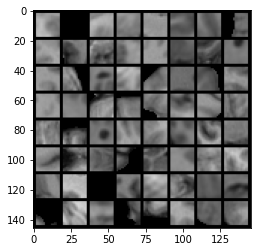

In [ ]:
inputs, classes = next(iter(training_dataloader))# Get a batch of training data
out = torchvision.utils.make_grid(inputs[:,:,:,0])# Make a grid from batch
imshow(out)

# Training

In [ ]:
tmpdir = "saved"
if not (os.path.exists(tmpdir)):
    os.mkdir(tmpdir)

In [ ]:
#MODEL
model = Unet(input_size=1, output_size=4)
model = model.to(device)
# define the optimizer
optimizer = Adam(model.parameters())
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

In [ ]:
train_loss_all = []
train_acc_all = []
val_loss_all = []
val_acc_all = []
best_acc = 0.0
best_loss = 1e+5
early_count = 0
dice=True
training = True
epoch = 1

since = time.time()
while training:
    train_loss = 0
    train_accuracy = 0
    val_loss = 0
    val_accuracy = 0
    model.train()
    for b, batch in enumerate(training_dataloader):
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        pred = model(x)
        if multi:
          loss = calc_loss(pred,y)
          train_loss += loss.item()
        else:
          loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),y.squeeze(dim=1).long())
          train_loss += loss.item()
        loss.backward()
        optimizer.step()
        # compute the accuracy
        pred = pred.max(1, keepdim=True)[1]
        batch_accuracy = pred.eq(y.view_as(pred).long())
        train_accuracy += (batch_accuracy.sum().item() / np.prod(y.shape))
    model.eval()
    for a, batch in enumerate(validation_dataloader):
        x = batch[0].to(device)
        y = batch[1].to(device)
        with torch.no_grad():
            pred = model(x)
            if multi:
              loss = calc_loss(pred, y)
              val_loss += loss.item()
            else:
              loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),
                                y.squeeze(dim=1).long())
              val_loss += loss.item()
            pred = pred.max(1, keepdim=True)[1]
            batch_accuracy = pred.eq(y.view_as(pred).long())
            val_accuracy += batch_accuracy.sum().item() / np.prod(y.shape)
    train_loss /= (b + 1)
    train_accuracy /= (b + 1)
    val_loss /= (a + 1)
    val_accuracy /= (a + 1)

    train_loss_all.append(train_loss)
    train_acc_all.append(train_accuracy)
    val_loss_all.append(val_loss)
    val_acc_all.append(val_accuracy)
    print('Epoch {:d} train_loss {:.4f} train_acc {:.4f} val_loss {:.4f} val_acc {:.4f}'.format(
        epoch,
        train_loss,
        train_accuracy,
        val_loss,
        val_accuracy))

    if val_loss < best_loss:
          # save weights
          best_loss = val_loss
          best_acc = val_accuracy
          print("val loss decreased...saving model")
          best_model_wts = copy.deepcopy(model.state_dict()) #copy its weights
          model_path = "{}/model.pt".format(tmpdir)
          torch.save(model.state_dict(),model_path)
          early_count = 0
    else:
          early_count += 1
    epoch += 1
    scheduler.step(val_loss)

    if early_count == 20:
        print("Early stopping")
        training = False
    if epoch >= num_epochs:
        training = False
model.load_state_dict(best_model_wts)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1 train_loss 0.3390 train_acc 0.8417 val_loss 0.2587 val_acc 0.8742
val loss decreased...saving model
Epoch 2 train_loss 0.2394 train_acc 0.8804 val_loss 0.2005 val_acc 0.8953
val loss decreased...saving model
Epoch 3 train_loss 0.2094 train_acc 0.8915 val_loss 0.1859 val_acc 0.9011
val loss decreased...saving model
Epoch 4 train_loss 0.1863 train_acc 0.9007 val_loss 0.1716 val_acc 0.9084
val loss decreased...saving model
Epoch 5 train_loss 0.1739 train_acc 0.9063 val_loss 0.1708 val_acc 0.9085
val loss decreased...saving model
Epoch 6 train_loss 0.1927 train_acc 0.8986 val_loss 0.1890 val_acc 0.8950
Epoch 7 train_loss 0.1736 train_acc 0.9057 val_loss 0.1686 val_acc 0.9093
val loss decreased...saving model
Epoch 8 train_loss 0.1628 train_acc 0.9105 val_loss 0.1600 val_acc 0.9130
val loss decreased...saving model
Epoch 9 train_loss 0.1540 train_acc 0.9146 val_loss 0.1600 val_acc 0.9132
val loss decreased...saving model
Epoch 10 train_loss 0.1875 train_acc 0.8997 val_loss 0.1618 va

# Plotting Results

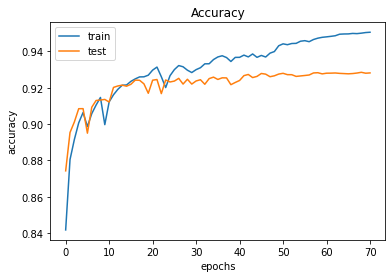

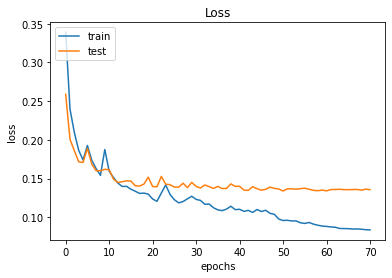

In [ ]:
# training and val accuracy
plt.figure()
plt.plot(train_acc_all)
plt.plot(val_acc_all)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("{}/accuracy.png".format(tmpdir))

# training and val loss
plt.figure()
plt.plot(train_loss_all)
plt.plot(val_loss_all)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("{}/loss.png".format(tmpdir))

# Evalutaion

In [ ]:
model_path = "{}/model.pt".format(tmpdir)
#MODEL
model = Unet(input_size=1, output_size=4)
model = model.to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
m_mean = evaluation(validation_path)
m_mean

SCAN: IBSR_11 dice_CSF:  0.8971377877387122 dice_GM: 0.9412853339605073 dice_WM: 0.960327020169661 hd_CSF:  8.660254037844387 hd_GM:  10.63014581273465 hd_WM:  7.280109889280518 vd_CSF:  0.006422786931024853 vd_GM:  0.02335865441956792 vd_WM:  0.018188795521368872
SCAN: IBSR_14 dice_CSF:  0.9274300467517969 dice_GM: 0.9568177645695403 dice_WM: 0.9528611584843848 hd_CSF:  17.916472867168917 hd_GM:  7.14142842854285 hd_WM:  6.48074069840786 vd_CSF:  0.06781617487915735 vd_GM:  0.0071105942096157115 vd_WM:  0.00264861683343143
SCAN: IBSR_17 dice_CSF:  0.9483519335582663 dice_GM: 0.948241613001906 dice_WM: 0.9279882004336517 hd_CSF:  15.588457268119896 hd_GM:  7.54983443527075 hd_WM:  10.04987562112089 vd_CSF:  0.01581616226658081 vd_GM:  0.014402243684699098 vd_WM:  0.05115472497020134
SCAN: IBSR_13 dice_CSF:  0.8991256327657616 dice_GM: 0.9379033339315876 dice_WM: 0.9146406264098734 hd_CSF:  11.224972160321824 hd_GM:  10.246950765959598 hd_WM:  10.344080432788601 vd_CSF:  0.0329501222051

,count,mean,std,min,25%,50%,75%,max
DSC_CSF,5.0,0.920689,0.022051,0.897138,0.899126,0.927430,0.931399,0.948352
DSC_GM,5.0,0.942719,0.010408,0.929349,0.937903,0.941285,0.948242,0.956818
DSC_WM,5.0,0.938487,0.018480,0.914641,0.927988,0.936618,0.952861,0.960327
hd_CSF,5.0,14.986163,5.149626,8.660254,11.224972,15.588457,17.916473,21.540659
hd_GM,5.0,8.394297,1.915653,6.403124,7.141428,7.549834,10.246951,10.630146
hd_WM,5.0,8.504281,1.687157,6.480741,7.280110,8.366600,10.049876,10.344080
vd_CSF,5.0,0.032701,0.023820,0.006423,0.015816,0.032950,0.040499,0.067816
vd_GM,5.0,0.026815,0.022702,0.007111,0.014402,0.023359,0.023689,0.065513
vd_WM,5.0,0.041787,0.044382,0.002649,0.018189,0.022220,0.051155,0.114722


In [ ]:
m_mean = evaluation(training_path)
print(m_mean)

SCAN: IBSR_06 dice_CSF:  0.9742439746576387 dice_GM: 0.9554241781411026 dice_WM: 0.9619741408901942 hd_CSF:  5.0 hd_GM:  6.164414002968976 hd_WM:  6.4031242374328485 vd_CSF:  0.007331887201735358 vd_GM:  0.015038417411257518 vd_WM:  0.0034860374057347028
SCAN: IBSR_09 dice_CSF:  0.9752516626085692 dice_GM: 0.9588924376135998 dice_WM: 0.9665271323246795 hd_CSF:  18.411952639521967 hd_GM:  6.782329983125268 hd_WM:  5.477225575051661 vd_CSF:  0.002401397176539077 vd_GM:  7.565522831667117e-05 vd_WM:  0.004381866714269377
SCAN: IBSR_16 dice_CSF:  0.961146737080347 dice_GM: 0.9740071659020477 dice_WM: 0.9712671193300142 hd_CSF:  5.385164807134504 hd_GM:  7.615773105863909 hd_WM:  10.862780491200215 vd_CSF:  0.009178947368421052 vd_GM:  0.0015296451538633791 vd_WM:  0.005391740704568082
SCAN: IBSR_05 dice_CSF:  0.9648048135126318 dice_GM: 0.9589904056056912 dice_WM: 0.9611101010862448 hd_CSF:  3.0 hd_GM:  6.708203932499369 hd_WM:  5.0990195135927845 vd_CSF:  0.0015235055136390016 vd_GM:  0.0

In [ ]:
m_mean=evaluation_test(test_path)
print(m_mean)

None
